In [11]:
!pip install timm torchinfo -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
from torchinfo import summary
import time
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


In [13]:
#Define the SE Block (my approach)

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    This is YOUR novel contribution!
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        # x shape: (batch, num_patches, channels)
        batch_size, num_patches, channels = x.shape

        # Step 1: SQUEEZE - Global average pooling
        y = x.mean(dim=1)  # (batch, channels)

        # Step 2: EXCITATION - Learn channel importance
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))

        # Step 3: SCALE - Multiply by channel weights
        y = y.unsqueeze(1)  # (batch, 1, channels)
        return x * y

In [14]:
#Modify Vision Transformer to Add SE Blocks (HYBRID VERSION)
class SEViTBlock(nn.Module):
    """
    Modified Transformer Block with SE attention (Hybrid Approach)
    Combines spatial attention + channel attention
    """
    def __init__(self, original_block, embed_dim):
        super().__init__()
        self.original_block = original_block
        self.se_block = SEBlock(embed_dim, reduction=16)

    def forward(self, x):
        # Original transformer block (spatial attention + MLP)
        x = self.original_block(x)
        # Add SE block as auxiliary channel attention (HYBRID)
        x = x + 0.1 * self.se_block(x)
        return x

def create_se_vit(use_se=True):
    """
    Create ViT model with optional SE blocks
    """
    # Load tiny ViT (small for fast training)
    model = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=False,
        num_classes=10,
        img_size=224
    )

    if use_se:
        # Modify blocks to include SE
        embed_dim = model.embed_dim

        # Wrap each transformer block with SE
        new_blocks = []
        for block in model.blocks:
            new_blocks.append(SEViTBlock(block, embed_dim))
        model.blocks = nn.Sequential(*new_blocks)
        print("Created SE-ViT HYBRID (Spatial + Channel Attention)")
    else:
        print("Created Baseline ViT (no SE)")

    return model

In [15]:
#Prepare CIFAR-10 Dataset
def get_cifar10_loaders(batch_size=128):
    """
    CIFAR-10 Dataset:
    - 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
    - 50,000 training images
    - 10,000 test images
    - Each image: 32x32 pixels (we resize to 224x224 for ViT)
    """

    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.Resize(224),  # ViT expects 224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010)),
    ])

    # No augmentation for test
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010)),
    ])

    # Download CIFAR-10
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    print(f"CIFAR-10 loaded: {len(trainset)} train, {len(testset)} test images")
    return trainloader, testloader

# CIFAR-10 class names
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
#Training Function
def train_one_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Print progress every 50 batches
        if (batch_idx + 1) % 50 == 0:
            print(f'  Batch [{batch_idx+1}/{len(trainloader)}] | '
                  f'Loss: {running_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


In [17]:
#Main Training Loop
def train_model(model_type='baseline', num_epochs=20, lr=0.001):
    """
    Train either baseline ViT or SE-ViT

    model_type: 'baseline' or 'se-vit'
    num_epochs: Number of training epochs (20 is reasonable, reduce to 10 for speed)
    """
    print(f"\n{'='*60}")
    print(f"Training {model_type.upper()}")
    print(f"{'='*60}\n")

    # Create model
    use_se = (model_type == 'se-vit')
    model = create_se_vit(use_se=use_se).to(device)

    # Print model summary
    print("\nModel Architecture:")
    summary(model, input_size=(1, 3, 224, 224), device=str(device))

    # Get data
    trainloader, testloader = get_cifar10_loaders(batch_size=128)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    best_acc = 0.0
    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')

        # Train
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)

        # Test
        test_loss, test_acc = test(model, testloader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'{model_type}_best.pth')

        # Print epoch summary
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')

    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"{'='*60}\n")

    return model, history, best_acc, total_time


In [18]:
#Visualization
def plot_results(history_baseline, history_se, save_path='results.png'):
    """
    Plot training curves for comparison
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history_baseline['test_acc'], label='Baseline ViT', marker='o')
    axes[0].plot(history_se['test_acc'], label='SE-ViT (Ours)', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Test Accuracy (%)')
    axes[0].set_title('Test Accuracy Comparison')
    axes[0].legend()
    axes[0].grid(True)

    # Loss plot
    axes[1].plot(history_baseline['test_loss'], label='Baseline ViT', marker='o')
    axes[1].plot(history_se['test_loss'], label='SE-ViT (Ours)', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Test Loss')
    axes[1].set_title('Test Loss Comparison')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Results saved to {save_path}")

In [19]:

# RUN EXPERIMENTS

def run_all_experiments():
    """
    Run both baseline and SE-ViT experiments
    """
    # Experiment settings
    NUM_EPOCHS = 15  # Reduce to 10 if you're in a hurry
    LEARNING_RATE = 0.001

    print("\n" + "="*80)
    print("STARTING EXPERIMENTS: Baseline ViT vs SE-ViT")
    print("="*80)

    # Experiment 1: Baseline ViT
    print("\nEXPERIMENT 1: Baseline ViT (No SE blocks)")
    model_baseline, history_baseline, acc_baseline, time_baseline = train_model(
        model_type='baseline',
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE
    )

    # Experiment 2: SE-ViT
    print("\n EXPERIMENT 2: SE-ViT (With SE blocks)")
    model_se, history_se, acc_se, time_se = train_model(
        model_type='se-vit',
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE
    )

    # Print comparison
    print("\n" + "="*80)
    print("FINAL RESULTS COMPARISON")
    print("="*80)
    print(f"{'Model':<20} {'Best Accuracy':<20} {'Training Time':<20}")
    print("-"*80)
    print(f"{'Baseline ViT':<20} {acc_baseline:>6.2f}%{'':<13} {time_baseline/60:>6.2f} min")
    print(f"{'SE-ViT (Ours)':<20} {acc_se:>6.2f}%{'':<13} {time_se/60:>6.2f} min")
    print("="*80)

    # Calculate improvement
    improvement = acc_se - acc_baseline
    if improvement > 0:
        print(f"\n SE-ViT improves accuracy by {improvement:.2f}%")
    else:
        print(f"\nSE-ViT decreases accuracy by {abs(improvement):.2f}%")
        print("   (This is still a valid result for your paper!)")

    # Plot results
    plot_results(history_baseline, history_se)

    return {
        'baseline': {'model': model_baseline, 'history': history_baseline,
                    'accuracy': acc_baseline, 'time': time_baseline},
        'se_vit': {'model': model_se, 'history': history_se,
                  'accuracy': acc_se, 'time': time_se}
    }



STARTING EXPERIMENTS: Baseline ViT vs SE-ViT

EXPERIMENT 1: Baseline ViT (No SE blocks)

Training BASELINE

Created Baseline ViT (no SE)

Model Architecture:
CIFAR-10 loaded: 50000 train, 10000 test images

Epoch [1/15]
  Batch [50/391] | Loss: 2.091 | Acc: 21.92%
  Batch [100/391] | Loss: 2.034 | Acc: 24.06%
  Batch [150/391] | Loss: 1.999 | Acc: 24.88%
  Batch [200/391] | Loss: 1.968 | Acc: 25.90%
  Batch [250/391] | Loss: 1.938 | Acc: 27.10%
  Batch [300/391] | Loss: 1.911 | Acc: 28.26%
  Batch [350/391] | Loss: 1.884 | Acc: 29.23%
Train Loss: 1.8619 | Train Acc: 30.14%
Test Loss: 1.7003 | Test Acc: 38.03%
Best Test Acc: 38.03%

Epoch [2/15]
  Batch [50/391] | Loss: 1.658 | Acc: 38.78%
  Batch [100/391] | Loss: 1.642 | Acc: 38.90%
  Batch [150/391] | Loss: 1.630 | Acc: 39.37%
  Batch [200/391] | Loss: 1.620 | Acc: 39.81%
  Batch [250/391] | Loss: 1.601 | Acc: 40.73%
  Batch [300/391] | Loss: 1.588 | Acc: 41.28%
  Batch [350/391] | Loss: 1.580 | Acc: 41.58%
Train Loss: 1.5753 | Trai

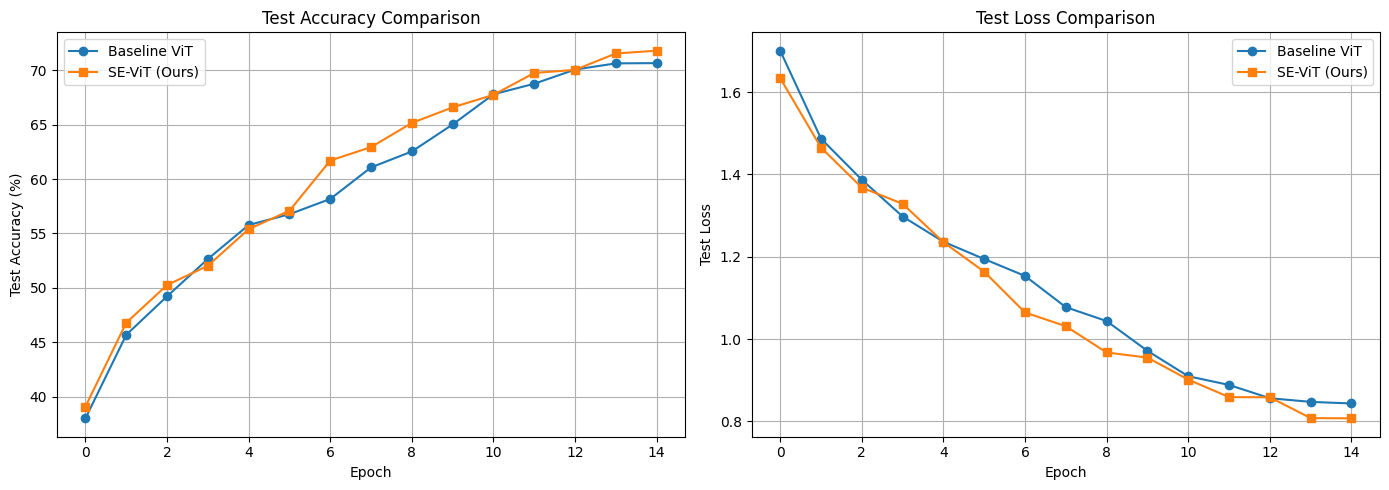

Results saved to results.png


In [20]:
#QUICK TEST MODE (For debugging - faster)

def quick_test():
    """
    Quick test with just 2 epochs to verify everything works
    Use this first to make sure code runs!
    """
    print("="*80)

    model_baseline, history_baseline, acc_baseline, time_baseline = train_model(
        model_type='baseline',
        num_epochs=2,
        lr=0.001
    )

    model_se, history_se, acc_se, time_se = train_model(
        model_type='se-vit',
        num_epochs=2,
        lr=0.001
    )

    print(f"  Baseline: {acc_baseline:.2f}% | SE-ViT: {acc_se:.2f}%")
    print("\nNow run: results = run_all_experiments() for full training")


# MAIN EXECUTION

if __name__ == "__main__":
    # OPTION 1: Quick test first
    # Uncomment this line to do a 2-epoch test first:
    # quick_test()

    # OPTION 2: Run full experiments
    results = run_all_experiments()

